In [1]:
import geopandas as gpd
from dask.distributed import Client, LocalCluster
from dask import delayed, dataframe as dd
from tqdm import tqdm
import dask
import libpysal
import pandas as pd
from libpysal.weights import W
import momepy
import contextily as ctx
from shapely.wkb import loads
import inequality

c:\ProgramData\anaconda3\envs\processor\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
local_crs = 27700
place = "test"
lat = 55.86421405612109
lng = -4.251846930489373
country = "UK"
crs=4326
radius=1

In [3]:
daskCluster = LocalCluster(threads_per_worker=2,
                n_workers=8, memory_limit='70GB')

client = Client(daskCluster)

client

c:\ProgramData\anaconda3\envs\processor\Lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 58507 instead
  warnings.warn(
2023-12-15 16:25:42,105 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 63.92 GiB
2023-12-15 16:25:42,121 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 63.92 GiB
2023-12-15 16:25:42,137 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 63.92 GiB
2023-12-15 16:25:42,155 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 63.92 GiB
2023-12-15 16:25:42,170 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 63.92 GiB
2023-12-15 16:25:42,189 - distributed.nanny.memory - WARNING - Ignoring p

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:58507/status,
Dashboard: http://127.0.0.1:58507/status,Workers: 8
Total threads: 16,Total memory: 511.38 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58511,Workers: 8
Dashboard: http://127.0.0.1:58507/status,Total threads: 16
Started: Just now,Total memory: 511.38 GiB
Comm: tcp://127.0.0.1:58554,Total threads: 2
Dashboard: http://127.0.0.1:58559/status,Memory: 63.92 GiB
Nanny: tcp://127.0.0.1:58514,


In [4]:
# three_queen_region = gpd.read_parquet(f"./output/{place}/three_queen_region_p3.pq")
# buildings = gpd.read_parquet(f"./output/{place}/buildings_p3.pq")
# streets = gpd.read_parquet(f"./output/{place}/streets_p3.pq")
# tessellation = gpd.read_parquet(f"./output/{place}/tessellation_p3.pq")
# adjlist_combined = None
# cells_in_expanded_region_200 = None
# cells_in_region = None

In [5]:
tessellation = pd.read_parquet(f"./output/{place}/tessellation_p1.pq",engine='fastparquet')
tessellation['geometry'] = tessellation['geometry'].apply(lambda x: loads(x) if x else None)
tessellation = gpd.GeoDataFrame(tessellation, geometry="geometry").set_crs(local_crs)

buildings = gpd.read_parquet(f"./output/{place}/buildings_p1.pq").to_crs(local_crs)
rail = gpd.read_parquet(f"./output/{place}/rail_raw.pq").to_crs(local_crs).reset_index(drop=True)
streets = gpd.read_parquet(f"./output/{place}/streets_raw.pq").to_crs(local_crs).explode()


C:\Users\reube\AppData\Local\Temp\ipykernel_13124\2046041374.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  streets = gpd.read_parquet(f"./output/{place}/streets_raw.pq").to_crs(local_crs).explode()


In [6]:
print("computing queen_1")
queen_1 = libpysal.weights.contiguity.Queen.from_dataframe(tessellation, ids="uID", silence_warnings=True)
print("computing queen_3")
queen_3 = momepy.sw_high(k=3, weights=queen_1)
print("computing dist_200")
dist200 = libpysal.weights.DistanceBand.from_dataframe(buildings, 200, ids='uID')

buildings_out = buildings
print("computing neighbours200")
buildings_out["buildings_neighbours_200"] = momepy.Neighbors(buildings, dist200, 'uID', weighted=True).series

tessellation_out = tessellation


computing queen_1
computing queen_3
computing dist_200


c:\ProgramData\anaconda3\envs\processor\Lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 19 disconnected components.
 There are 4 islands with ids: 2882, 4847, 8710, 40407.
  warnings.warn(message)


computing neighbours200


100%|██████████| 40936/40936 [00:00<00:00, 65363.30it/s]


In [7]:

### Building Area
buildings_out['building_area'] = momepy.Area(buildings).series
tessellation_out['tess_area'] = momepy.Area(tessellation_out).series

tessellation_out["tessellation_neighbours"] = momepy.Neighbors(tessellation_out, queen_3, 'uID', weighted=True).series

buildings_scattered = client.scatter(buildings)
streets_scattered = client.scatter(streets)
tessellation_scattered = client.scatter(tessellation_out)

dist200_scattered = client.scatter(dist200)
queen_1_scattered = client.scatter(queen_1)
queen_3_scattered = client.scatter(queen_3)



  0%|          | 0/40936 [00:00<?, ?it/s]

100%|██████████| 40936/40936 [00:00<00:00, 67369.49it/s]


In [8]:
# Assuming buildings_scattered is a GeoDataFrame and queen_1 is defined

jobs_names = ['building_circular_compactness', 'building_elongation', 'building_squareness', 'building_eri', 'building_orientation', "building_neighbour_dist", "building_neighbourhood_interbuilding_distance"]

jobs = [dask.delayed(momepy.CircularCompactness)(buildings_scattered), 
        dask.delayed(momepy.Elongation)(buildings_scattered), 
        dask.delayed(momepy.Squareness)(buildings_scattered),
        dask.delayed(momepy.EquivalentRectangularIndex)(buildings_scattered), 
        dask.delayed(momepy.Orientation)(buildings_scattered), 
        dask.delayed(momepy.NeighborDistance)(buildings_scattered, queen_1_scattered, 'uID'),
        dask.delayed(momepy.MeanInterbuildingDistance)(buildings_scattered, queen_1_scattered, 'uID', 3)
        ]

jobs_out = dask.compute(jobs)

# Assign the results back to the buildings GeoDataFrame
for index, field_name in enumerate(jobs_names):
    buildings_out[field_name] = jobs_out[0][index].series
    
buildings_scattered = client.scatter(buildings_out)



In [9]:
# Assuming buildings_scattered is a GeoDataFrame and queen_1 is defined

jobs_names = ["tess_convexity", "tess_covered_area", "tess_orientation"]

jobs = [dask.delayed(momepy.Convexity)(tessellation_scattered), 
        dask.delayed(momepy.CoveredArea)(tessellation_scattered, queen_1_scattered, "uID"),
        dask.delayed(momepy.Orientation)(tessellation_scattered)]

jobs_out = dask.compute(jobs)

# Assign the results back to the buildings GeoDataFrame
for index, field_name in enumerate(jobs_names):
    tessellation_out[field_name] = jobs_out[0][index].series

tessellation_scattered = client.scatter(tessellation_out)



In [10]:
# Assuming buildings_scattered is a GeoDataFrame and queen_1 is defined

jobs_names = ['building_circular_compactness_weight', 'building_elongation_weight', 'building_squareness_weight', 'building_eri_weight', "building_neighbour_dist_weight", "building_neighbourhood_interbuilding_distance_weight", 'building_orientation_weight']

jobs = [dask.delayed(momepy.WeightedCharacter)(buildings_scattered,
                                                        values='building_circular_compactness',
                                                        spatial_weights=queen_3_scattered,
                                                        unique_id='uID'),
        dask.delayed(momepy.WeightedCharacter)(buildings_scattered,
                                                        values='building_elongation',
                                                        spatial_weights=queen_3_scattered,
                                                        unique_id='uID'),
        dask.delayed(momepy.WeightedCharacter)(buildings_scattered,
                                                        values='building_squareness',
                                                        spatial_weights=queen_3_scattered,
                                                        unique_id='uID'),
        dask.delayed(momepy.WeightedCharacter)(buildings_scattered,
                                                        values='building_eri',
                                                        spatial_weights=queen_3_scattered,
                                                        unique_id='uID'),
        dask.delayed(momepy.WeightedCharacter)(buildings_scattered,
                                                        values='building_neighbour_dist',
                                                        spatial_weights=queen_3_scattered,
                                                        unique_id='uID'),
        dask.delayed(momepy.WeightedCharacter)(buildings_scattered,
                                                        values='building_neighbourhood_interbuilding_distance',
                                                        spatial_weights=queen_3_scattered,
                                                        unique_id='uID'),
        dask.delayed(momepy.WeightedCharacter)(buildings_scattered,
                                                        values='building_orientation',
                                                        spatial_weights=queen_3_scattered,
                                                        unique_id='uID')]

jobs_out = dask.compute(*jobs)

# Assign the results back to the buildings GeoDataFrame
for index, field_name in enumerate(jobs_names):
    buildings_out[field_name] = jobs_out[index].series

buildings_scattered = client.scatter(buildings_out)



In [11]:
# Assuming buildings_scattered is a GeoDataFrame and queen_1 is defined

jobs_names = ["tess_convexity_weight", "tess_covered_area_weight", "tess_orientation_weight", "tess_rea_theil", "building_neighbourhood_interbuilding_distance_weight"]

jobs = [dask.delayed(momepy.WeightedCharacter)(tessellation_scattered,
                                                        values="tess_convexity",
                                                        spatial_weights=queen_3_scattered,
                                                        unique_id='uID'),
        dask.delayed(momepy.WeightedCharacter)(tessellation_scattered,
                                                        values='tess_covered_area',
                                                        spatial_weights=queen_3_scattered,
                                                        unique_id='uID'),
        dask.delayed(momepy.WeightedCharacter)(tessellation_scattered,
                                                        values='tess_orientation',
                                                        spatial_weights=queen_3_scattered,
                                                        unique_id='uID'),
        dask.delayed(momepy.Theil)(tessellation_scattered, values='tess_area', spatial_weights=queen_3_scattered, unique_id='uID'),
        dask.delayed(momepy.WeightedCharacter)(buildings_scattered,
                                                        values='building_neighbourhood_interbuilding_distance',
                                                        spatial_weights=queen_3_scattered,
                                                        unique_id='uID')]

jobs_out = dask.compute(*jobs)

# Assign the results back to the buildings GeoDataFrame
for index, field_name in enumerate(jobs_names):
    if index == len(jobs_names) - 1:  # Check if it's the last iteration
        buildings_out[field_name] = jobs_out[index].series
    else:
        tessellation_out[field_name] = jobs_out[index].series
        


In [12]:
buildings_out.to_parquet(f"output/{place}/momepy_building_local_out.pq")
buildings.to_parquet(f"output/{place}/momepy_building_dist200_out.pq")
tessellation_out.to_parquet(f"output/{place}/momepy_tessellation_out.pq")

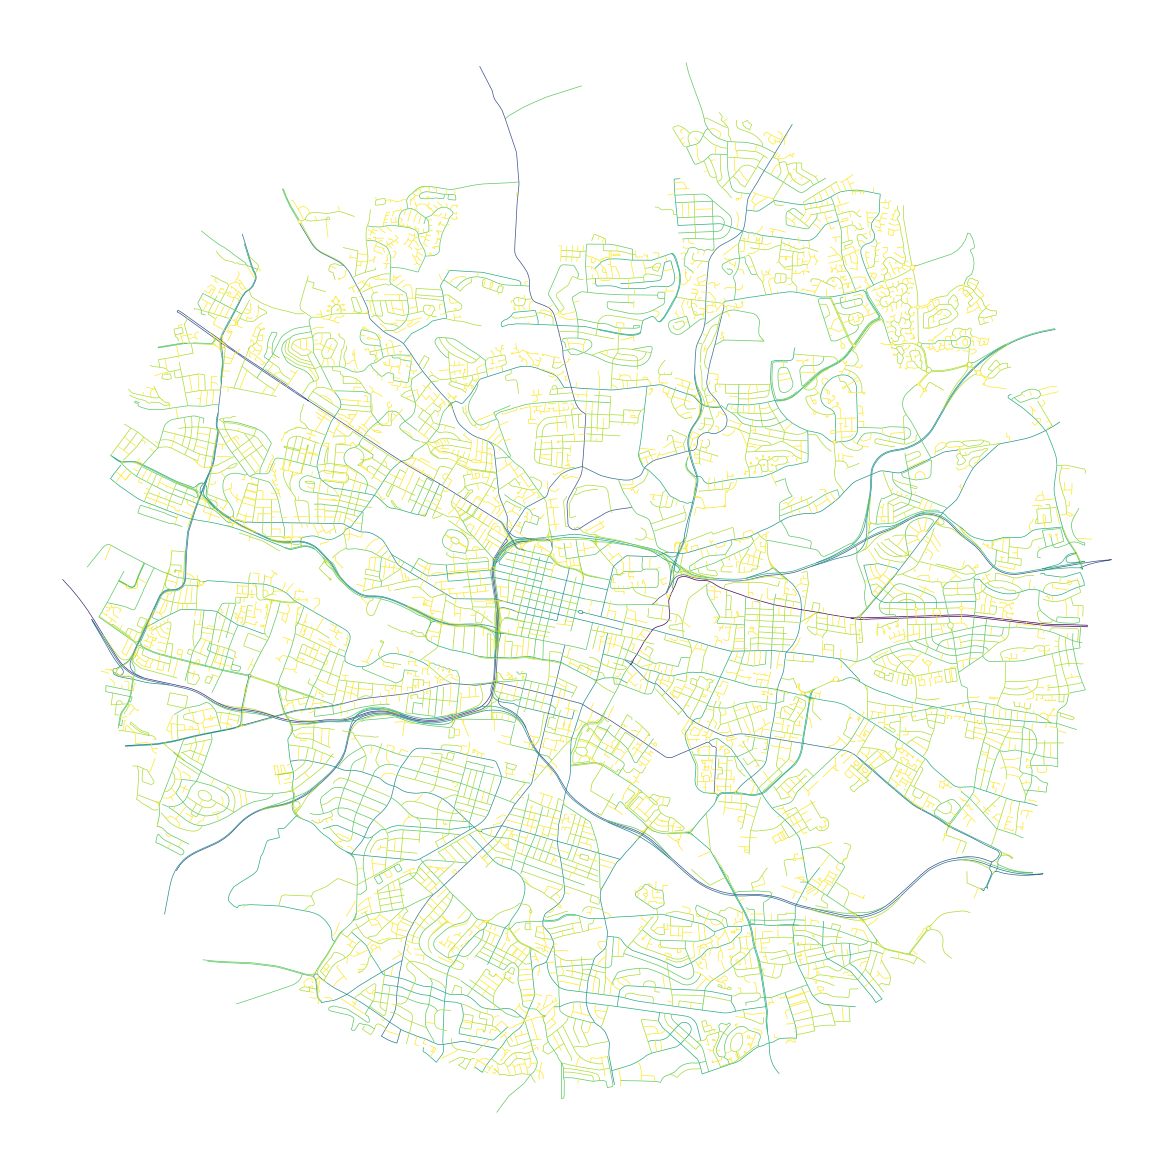

In [13]:
continuity = momepy.COINS(streets)

stroke_attr = continuity.stroke_attribute()

stroke_gdf = continuity.stroke_gdf()

stroke_gdf.plot(stroke_gdf.length,
                figsize=(15, 15),
                cmap="viridis_r",
                linewidth=.5,
                scheme="headtailbreaks"
               ).set_axis_off()

stroke_gdf["length"] = stroke_gdf.length

stroke_gdf.to_parquet(f"output/{place}/stroke_gdf.pq")

In [14]:
# ## Create Weights
# buildings_out_combined = pd.DataFrame()
# buildings_combined = pd.DataFrame()
# tessellation_out_combined = pd.DataFrame()

# for cell_index in tqdm(three_queen_region):
#     print("new cell", cell_index)
    
#     if buildings[buildings['uID'].isin(three_queen_region[cell_index])].empty:
#         continue
    
#     filtered_df = adjlist_combined[
#             adjlist_combined['focal'].isin(three_queen_region[cell_index]) & 
#             adjlist_combined['neighbor'].isin(three_queen_region[cell_index])
#         ]
#     buildings = buildings[buildings["uID"].isin(cells_in_expanded_region_200)]
    
#     queen_1 = W.from_adjlist(filtered_df)

#     queen_3 = momepy.sw_high(k=3, weights=queen_1)

#     dist200 = libpysal.weights.DistanceBand.from_dataframe(buildings, 200, ids='uID')
    
#     buildings = buildings[buildings['uID'].isin(three_queen_region[cell_index])]

#     buildings["buildings_neighbours_200"] = momepy.Neighbors(buildings, dist200, 'uID', weighted=True).series

#     buildings_out = buildings[buildings["uID"].isin(cells_in_region[cell_index])]
    
#     queen_3_adjlist = queen_3.to_adjlist()

#     # Get unique values from both columns
#     unique_focal = queen_3_adjlist['focal'].unique()
#     unique_neighbor = queen_3_adjlist['neighbor'].unique()

#     # Combine and get unique values across both columns
#     all_unique_values = pd.unique(pd.concat([pd.Series(unique_focal), pd.Series(unique_neighbor)]))
    
#     tessellation_out = tessellation[tessellation["uID"].isin(all_unique_values)]
    
#     ### Building Area
#     buildings['building_area'] = momepy.Area(buildings).series
#     tessellation_out['tess_area'] = momepy.Area(tessellation_out).series
    
#     tessellation_out["tessellation_neighbours"] = momepy.Neighbors(tessellation_out, queen_3, 'uID', weighted=True).series
    
#     buildings_scattered = client.scatter(buildings)
#     streets_scattered = client.scatter(streets)
#     tessellation_scattered = client.scatter(tessellation_out)

#     dist200_scattered = client.scatter(dist200)
#     queen_1_scattered = client.scatter(queen_1)
#     queen_3_scattered = client.scatter(queen_3)
    
#     buildings_out = buildings
    
#     # Assuming buildings_scattered is a GeoDataFrame and queen_1 is defined
    
#     jobs_names = ['building_circular_compactness', 'building_elongation', 'building_squareness', 'building_eri', 'building_orientation', "building_neighbour_dist", "building_neighbourhood_interbuilding_distance"]

#     jobs = [dask.delayed(momepy.CircularCompactness)(buildings_scattered), 
#             dask.delayed(momepy.Elongation)(buildings_scattered), 
#             dask.delayed(momepy.Squareness)(buildings_scattered),
#             dask.delayed(momepy.EquivalentRectangularIndex)(buildings_scattered), 
#             dask.delayed(momepy.Orientation)(buildings_scattered), 
#             dask.delayed(momepy.NeighborDistance)(buildings_scattered, queen_1_scattered, 'uID'), 
#             dask.delayed(momepy.MeanInterbuildingDistance)(buildings_scattered, queen_1_scattered, 'uID', 3)]

#     jobs_out = dask.compute(jobs)

#     # Assign the results back to the buildings GeoDataFrame
#     for index, field_name in enumerate(jobs_names):
#         buildings_out[field_name] = jobs_out[0][index].series
        
#     buildings_scattered = client.scatter(buildings_out)

#     # Assuming buildings_scattered is a GeoDataFrame and queen_1 is defined

#     jobs_names = ["tess_convexity", "tess_covered_area", "tess_orientation"]

#     jobs = [dask.delayed(momepy.Convexity)(tessellation_scattered), 
#             dask.delayed(momepy.CoveredArea)(tessellation_scattered, queen_1_scattered, "uID"),
#             dask.delayed(momepy.Orientation)(tessellation_scattered)]

#     jobs_out = dask.compute(jobs)

#     # Assign the results back to the buildings GeoDataFrame
#     for index, field_name in enumerate(jobs_names):
#         tessellation_out[field_name] = jobs_out[0][index].series

#     tessellation_scattered = client.scatter(tessellation_out)
    
#     # Assuming buildings_scattered is a GeoDataFrame and queen_1 is defined

#     jobs_names = ['building_circular_compactness_weight', 'building_elongation_weight', 'building_squareness_weight', 'building_eri_weight', "building_neighbour_dist_weight", "building_neighbourhood_interbuilding_distance_weight", 'building_orientation_weight']

#     jobs = [dask.delayed(momepy.WeightedCharacter)(buildings_scattered,
#                                                             values='building_circular_compactness',
#                                                             spatial_weights=queen_3_scattered,
#                                                             unique_id='uID'),
#             dask.delayed(momepy.WeightedCharacter)(buildings_scattered,
#                                                             values='building_elongation',
#                                                             spatial_weights=queen_3_scattered,
#                                                             unique_id='uID'),
#             dask.delayed(momepy.WeightedCharacter)(buildings_scattered,
#                                                             values='building_squareness',
#                                                             spatial_weights=queen_3_scattered,
#                                                             unique_id='uID'),
#             dask.delayed(momepy.WeightedCharacter)(buildings_scattered,
#                                                             values='building_eri',
#                                                             spatial_weights=queen_3_scattered,
#                                                             unique_id='uID'),
#             dask.delayed(momepy.WeightedCharacter)(buildings_scattered,
#                                                             values='building_neighbour_dist',
#                                                             spatial_weights=queen_3_scattered,
#                                                             unique_id='uID'),
#             dask.delayed(momepy.WeightedCharacter)(buildings_scattered,
#                                                             values='building_neighbourhood_interbuilding_distance',
#                                                             spatial_weights=queen_3_scattered,
#                                                             unique_id='uID'),
#             dask.delayed(momepy.WeightedCharacter)(buildings_scattered,
#                                                             values='building_orientation',
#                                                             spatial_weights=queen_3_scattered,
#                                                             unique_id='uID')]

#     jobs_out = dask.compute(*jobs)

#     # Assign the results back to the buildings GeoDataFrame
#     for index, field_name in enumerate(jobs_names):
#         buildings_out[field_name] = jobs_out[index].series

#     buildings_scattered = client.scatter(buildings_out)
    
#     # Assuming buildings_scattered is a GeoDataFrame and queen_1 is defined

#     jobs_names = ["tess_convexity_weight", "tess_covered_area_weight", "tess_orientation_weight", "tess_rea_theil", "building_neighbourhood_interbuilding_distance_weight"]

#     jobs = [dask.delayed(momepy.WeightedCharacter)(tessellation_scattered,
#                                                             values="tess_convexity",
#                                                             spatial_weights=queen_3_scattered,
#                                                             unique_id='uID'),
#             dask.delayed(momepy.WeightedCharacter)(tessellation_scattered,
#                                                             values='tess_covered_area',
#                                                             spatial_weights=queen_3_scattered,
#                                                             unique_id='uID'),
#             dask.delayed(momepy.WeightedCharacter)(tessellation_scattered,
#                                                             values='tess_orientation',
#                                                             spatial_weights=queen_3_scattered,
#                                                             unique_id='uID'),
#             dask.delayed(momepy.Theil)(tessellation_scattered, values='tess_area', spatial_weights=queen_3_scattered, unique_id='uID'),
#             dask.delayed(momepy.WeightedCharacter)(buildings_scattered,
#                                                             values='building_neighbourhood_interbuilding_distance_weight',
#                                                             spatial_weights=queen_3_scattered,
#                                                             unique_id='uID')]

#     jobs_out = dask.compute(*jobs)

#     # Assign the results back to the buildings GeoDataFrame
#     for index, field_name in enumerate(jobs_names):
#         if index == len(jobs_names) - 1:  # Check if it's the last iteration
#             buildings_out[field_name] = jobs_out[index].series
#         else:
#             tessellation_out[field_name] = jobs_out[index].series
            
#     buildings_out.to_parquet(f"output/{place}/momepy_building_local_out_part{cell_index}.pq")
#     buildings.to_parquet(f"output/{place}/momepy_building_dist200_out_part{cell_index}.pq")
#     tessellation_out.to_parquet(f"output/{place}/momepy_tessellation_out_part{cell_index}.pq")
    
#     buildings_out = buildings_out.drop('geometry', axis=1)
#     tessellation_out = tessellation_out.drop(['geometry', 'centroid'], axis=1)
#     buildings = buildings.drop('geometry', axis=1)
    
#     if cell_index == 0:
#         buildings_out_combined = buildings_out[buildings_out["uID"].isin(cells_in_region[cell_index])]
#         buildings_combined = buildings[buildings["uID"].isin(cells_in_region[cell_index])]
#         tessellation_out_combined = tessellation_out[tessellation_out["uID"].isin(cells_in_region[cell_index])]
    
#     else:
#         buildings_out_combined = pd.concat([buildings_out_combined, buildings_out[buildings_out["uID"].isin(cells_in_region[cell_index])]], ignore_index=True)
#         buildings_combined = pd.concat([buildings_combined, buildings[buildings["uID"].isin(cells_in_region[cell_index])]], ignore_index=True)
#         tessellation_out_combined = pd.concat([tessellation_out_combined, tessellation_out[tessellation_out["uID"].isin(cells_in_region[cell_index])]], ignore_index=True)


In [15]:
buildings_out.to_parquet(f"./output/{place}/buildings_morphometric_var.pq")
tessellation_out.to_parquet(f"./output/{place}/tessellation_morphometric_var.pq")